In [1]:
# NYSE：New York Stock Exchange 纽约证券交易所
# 二十支股票：
# GOOG谷歌,TSLA特斯拉,AAPL苹果,AMZN亚马逊,MSFT微软,NVDA英伟达,INTC英特尔,QCOM高通,WDC西部数据,AMD超威,ORCL甲骨文,SAP思爱普,CSCO思科,BABA阿里巴巴,NOK诺基亚,T美国电话电报公司,VZ微讯,FB脸书,TWTR推特,SNAP色拉布

In [2]:
import numpy as np # 向量和矩阵 
import pandas as pd # 表格和数据处理 
import matplotlib.pyplot as plt # 绘图 
import seaborn as sns # 更多绘图功能

from dateutil.relativedelta import relativedelta # 处理不同格式的时间日期 
from scipy.optimize import minimize # 最小化函数

import statsmodels.formula.api as smf # statistics and econometrics 
import statsmodels.tsa.api as smt 
import statsmodels.api as sm 
import scipy.stats as scs

from itertools import product # 一些有用的函数 
from tqdm import tqdm_notebook

import warnings # 勿扰模式 
warnings.filterwarnings('ignore')

%matplotlib inline

import numpy as np                               # 向量和矩阵
import pandas as pd                              # 表格和数据处理
import matplotlib.pyplot as plt                  # 绘图
import seaborn as sns                            # 更多绘图功能

from dateutil.relativedelta import relativedelta # 处理不同格式的时间日期
from scipy.optimize import minimize              # 最小化函数

import statsmodels.formula.api as smf            # statistics and econometrics
import statsmodels.tsa.api as smt
import statsmodels.api as sm
import scipy.stats as scs

from itertools import product                    # 一些有用的函数
from tqdm import tqdm_notebook

import warnings                                  # 勿扰模式
warnings.filterwarnings('ignore')

%matplotlib inline

In [3]:
#R2，决定系数（在经济学中，可以理解为模型能够解释的方差比例），(-inf, 1] sklearn.metrics.r2_score
#平均绝对误差（Mean Absolute Error），这是一个易于解释的测度，因为它的计量单位和初始序列相同，[0, +inf) sklearn.metrics.mean_absolute_error
#中位绝对误差（Median Absolute Error），同样是一个易于解释的测度，对离群值的鲁棒性很好，[0, +inf) sklearn.metrics.median_absolute_error
#均方误差（Mean Squared Error），最常用的测度，给较大的错误更高的惩罚，[0, +inf) sklearn.metrics.mean_squared_error
#均方对数误差（Mean Squared Logarithmic Error），和MSE差不多，只不过先对序列取对数，因此能够照顾到较小的错误，通常用于具有指数趋势的数据，[0, +inf) sklearn.metrics.mean_squared_log_error
#平均绝对百分误差（Mean Absolute Percentage Error），类似MAE不过基于百分比——当你需要向管理层解释模型的质量时很方便——[0, +inf)，sklearn中没有实现。

In [4]:
# 引入上面提到的所有测度
from sklearn.metrics import r2_score, median_absolute_error, mean_absolute_error
from sklearn.metrics import median_absolute_error, mean_squared_error, mean_squared_log_error
from sklearn.model_selection import TimeSeriesSplit

# 自行实现sklearn没有提供的平均绝对百分误差很容易
def mean_absolute_percentage_error(y_true, y_pred): 
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

In [5]:
from pandas_datareader import data, wb
# 所研究的二十支股票的NYSE代码
tickers = ['GOOG','TSLA','AAPL','AMZN','MSFT','NVDA','INTC','QCOM','WDC','AMD','ORCL','SAP','CSCO','BABA',
           'NOK','T','VZ','FB','TWTR','SNAP']

# We would like five-years available data from 28/10/2013 until 10/28/2018.
start_date = '2017-10-28'
end_date = '2018-10-28'
# User pandas_reader.data.DataReader to load the desired data. As simple as that.
# panel_data = data.DataReader('AAPL', 'iex', start_date, end_date)
panel_data = data.DataReader(tickers, "iex", start_date, end_date)
# print(panel_data['close']) #一年的收盘值
panel_close_data = panel_data['close']
# print(panel_close_data)

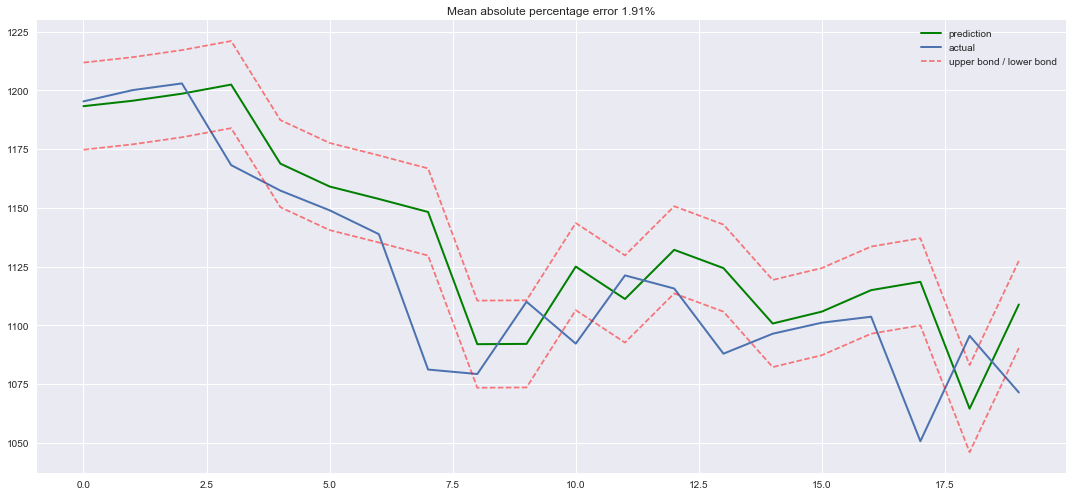

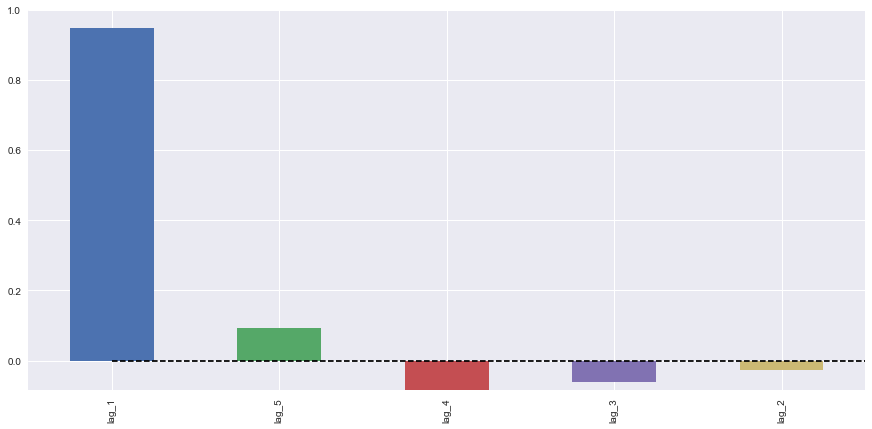

In [22]:
#时序数据上的线性模型
stock = pd.read_csv('/Users/BartSu/Desktop/GOOG-100back.csv', index_col=['Date'], parse_dates=['Date'])
data = pd.DataFrame(stock['Adj Close'].copy().astype(float))
data.columns = ["y"]

for i in range(1, 6):
    data["lag_{}".format(i)] = data.y.shift(i)

from sklearn.linear_model import LinearRegression
from sklearn.model_selection import cross_val_score

# 5折交叉验证
tscv = TimeSeriesSplit(n_splits=5)

def timeseries_train_test_split(X, y, test_size):
    test_index = int(len(X)*(1-test_size))

    X_train = X.iloc[:test_index]
    y_train = y.iloc[:test_index]
    X_test = X.iloc[test_index:]
    y_test = y.iloc[test_index:]

    return X_train, X_test, y_train, y_test

y = data.dropna().y #删除n/a的数据
X = data.dropna().drop(['y'], axis=1)

# 保留30%数据用于测试
X_train, X_test, y_train, y_test = timeseries_train_test_split(X, y, test_size=0.3)

def plotModelResults(model, X_train=X_train, X_test=X_test, plot_intervals=False, plot_anomalies=False):  
    prediction = model.predict(X_test)

    plt.figure(figsize=(15, 7))
    plt.plot(prediction, "g", label="prediction", linewidth=2.0)
    plt.plot(y_test.values, label="actual", linewidth=2.0)

    if plot_intervals:
        cv = cross_val_score(model, X_train, y_train, 
                                    cv=tscv, 
                                    scoring="neg_mean_absolute_error")
        mae = cv.mean() * (-1)
        deviation = cv.std()

        scale = 1.96
        lower = prediction - (mae + scale * deviation)
        upper = prediction + (mae + scale * deviation)

        plt.plot(lower, "r--", label="upper bond / lower bond", alpha=0.5)
        plt.plot(upper, "r--", alpha=0.5)

        if plot_anomalies:
            anomalies = np.array([np.NaN]*len(y_test))
            anomalies[y_test<lower] = y_test[y_test<lower]
            anomalies[y_test>upper] = y_test[y_test>upper]
            plt.plot(anomalies, "o", markersize=10, label = "Anomalies")

    error = mean_absolute_percentage_error(prediction, y_test)
    plt.title("Mean absolute percentage error {0:.2f}%".format(error))
    plt.legend(loc="best")
    plt.tight_layout()
    plt.grid(True);

def plotCoefficients(model):
    """
        绘制模型排序后的系数
    """

    coefs = pd.DataFrame(model.coef_, X_train.columns)
    coefs.columns = ["coef"]
    coefs["abs"] = coefs.coef.apply(np.abs)
    coefs = coefs.sort_values(by="abs", ascending=False).drop(["abs"], axis=1)

    plt.figure(figsize=(15, 7))
    coefs.coef.plot(kind='bar')
    plt.grid(True, axis='y')
    plt.hlines(y=0, xmin=0, xmax=len(coefs), linestyles='dashed');


# 机器学习
lr = LinearRegression()
lr.fit(X_train, y_train)

plotModelResults(lr, plot_intervals=True)
plotCoefficients(lr)

In [23]:
data.index = pd.to_datetime(data.index)
data["weekday"] = data.index.weekday
data["month"] = data.index.month


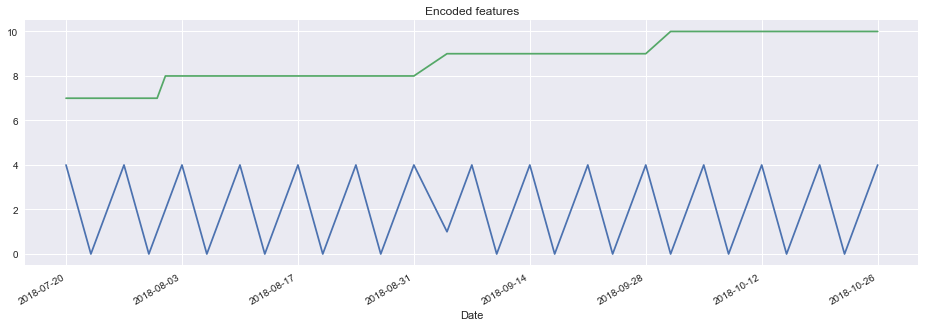

In [24]:
plt.figure(figsize=(16, 5))
plt.title("Encoded features")
data.weekday.plot()
data.month.plot()
plt.grid(True);

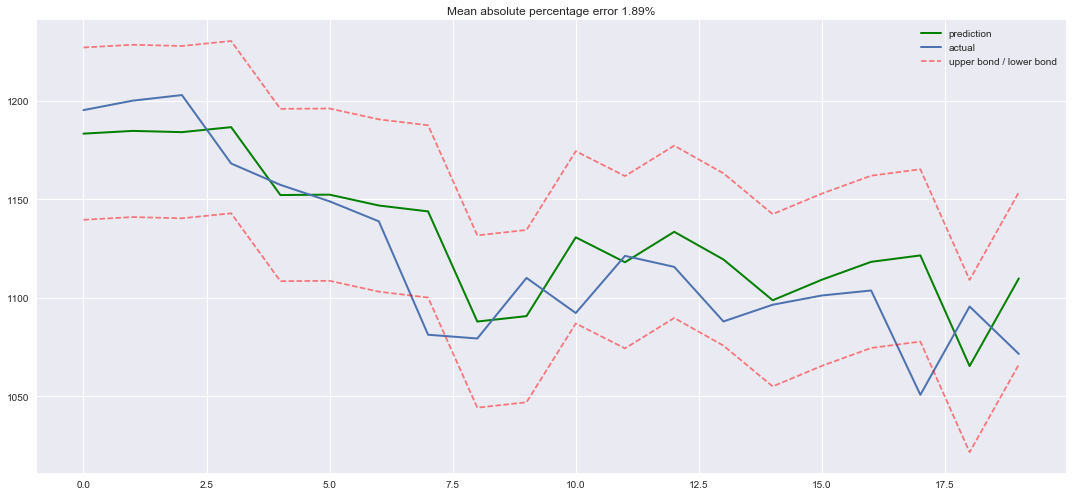

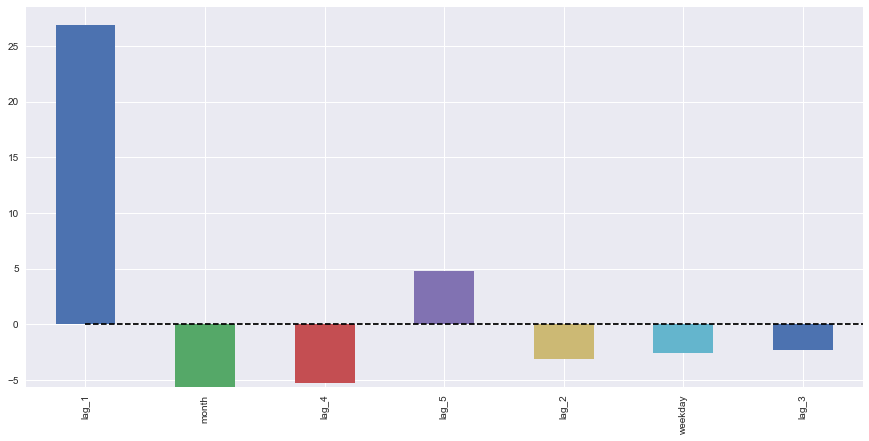

In [25]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()

y = data.dropna().y
X = data.dropna().drop(['y'], axis=1)

X_train, X_test, y_train, y_test = timeseries_train_test_split(X, y, test_size=0.3)

X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

lr = LinearRegression()
lr.fit(X_train_scaled, y_train)

plotModelResults(lr, X_train=X_train_scaled, X_test=X_test_scaled, plot_intervals=True)
plotCoefficients(lr)

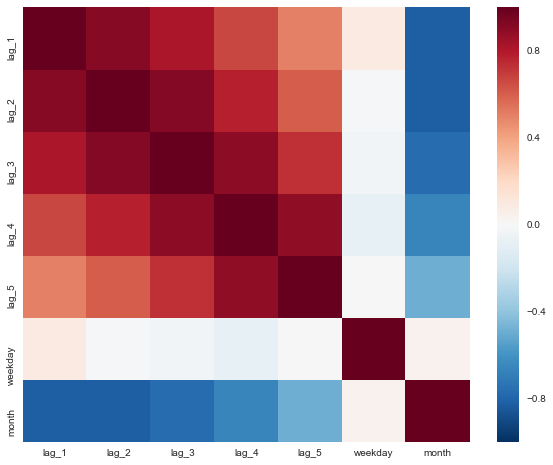

In [26]:
plt.figure(figsize=(10, 8))
sns.heatmap(X_train.corr());

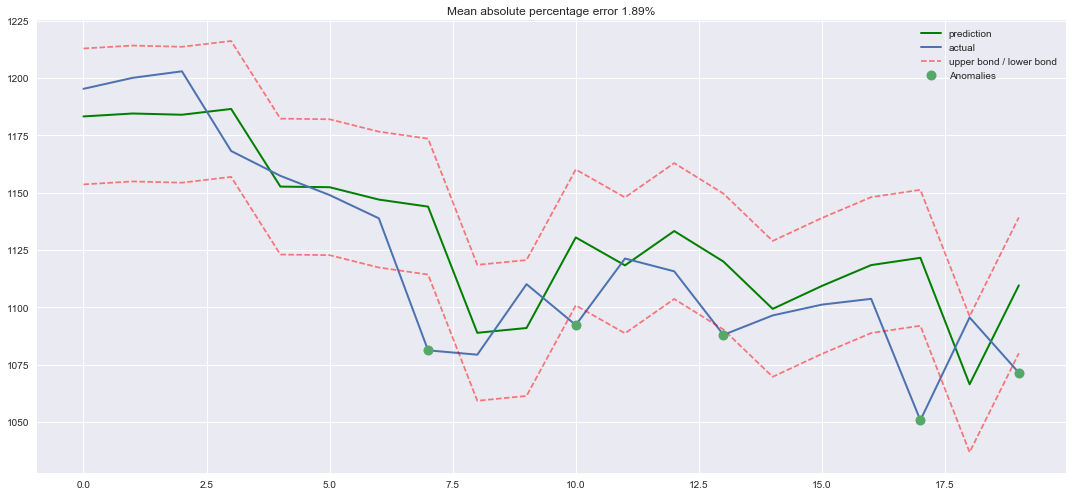

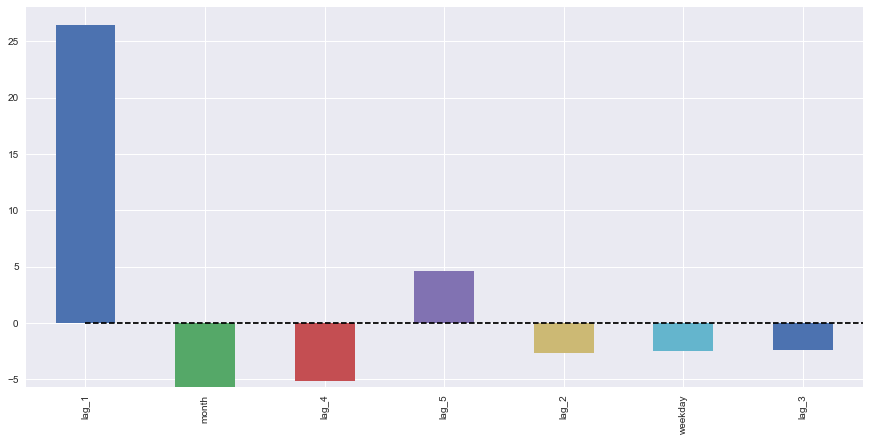

In [27]:
from sklearn.linear_model import LassoCV, RidgeCV

ridge = RidgeCV(cv=tscv)
ridge.fit(X_train_scaled, y_train)

plotModelResults(ridge, 
                 X_train=X_train_scaled, 
                 X_test=X_test_scaled, 
                 plot_intervals=True, plot_anomalies=True)
plotCoefficients(ridge)

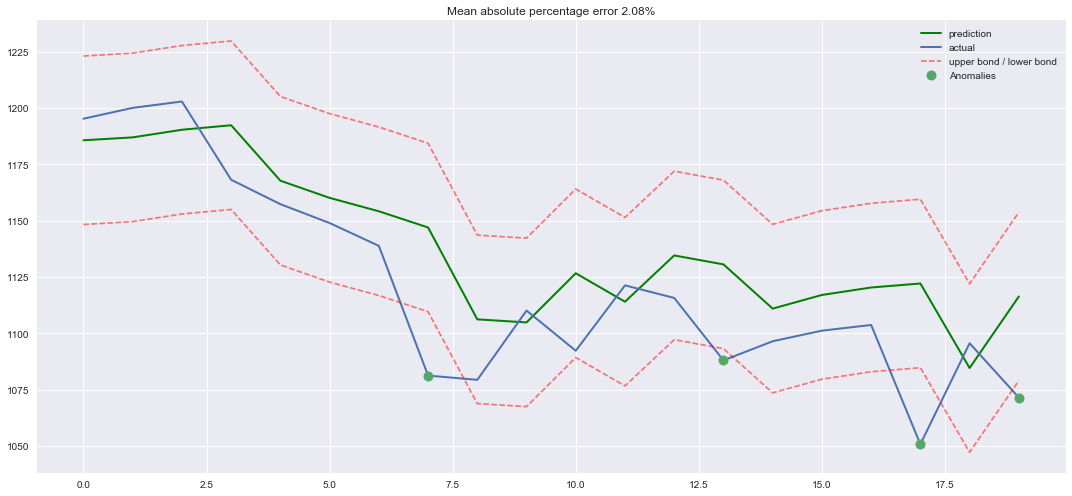

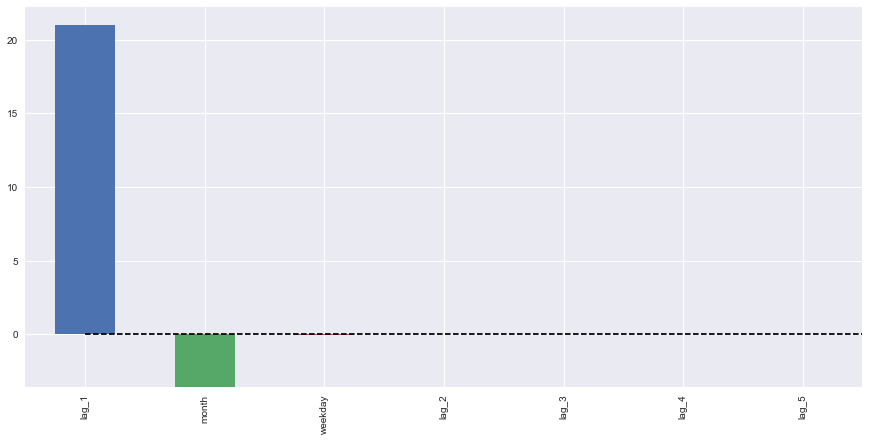

In [28]:
lasso = LassoCV(cv=tscv)
lasso.fit(X_train_scaled, y_train)

plotModelResults(lasso, 
                 X_train=X_train_scaled, 
                 X_test=X_test_scaled, 
                 plot_intervals=True, plot_anomalies=True)
plotCoefficients(lasso)

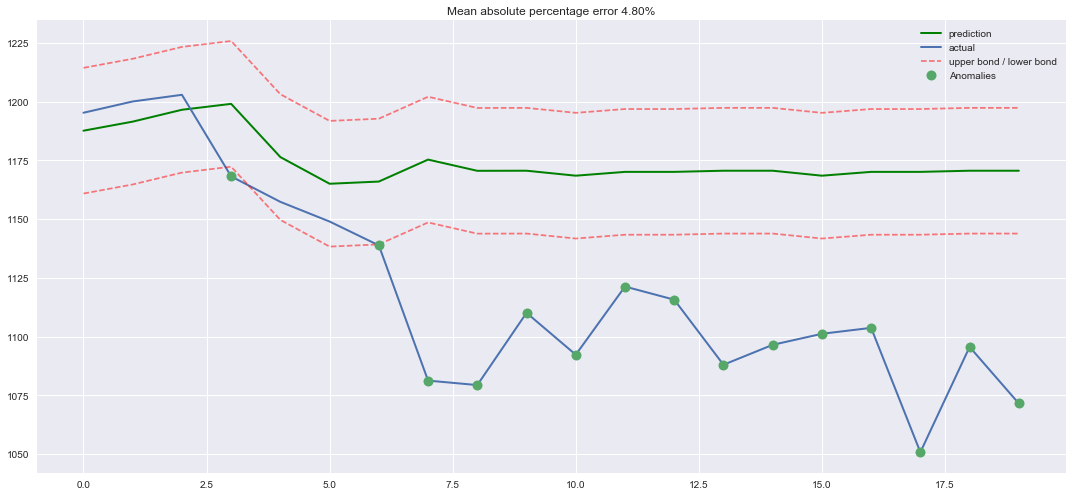

In [29]:
from xgboost import XGBRegressor 

xgb = XGBRegressor()
xgb.fit(X_train_scaled, y_train)

plotModelResults(xgb, 
                 X_train=X_train_scaled, 
                 X_test=X_test_scaled, 
plot_intervals=True, plot_anomalies=True)